In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # 词汇表大小
    "context_length": 1024,  # 上下文长度，最大输入词元的数量
    "emb_dim": 768,          # 嵌入维度
    "n_heads": 12,           # 注意力头的数量
    "n_layers": 12,          # 层数
    "drop_rate": 0.1,        # dropout率
    "qkv_bias": False        # 查询-键-值偏置
}

In [2]:
'''
这是一个GPT模型的基本结构
其中有两个模块是没有实现的
1. Transformer模块，使用DummyTransformerBlock代替
2. 层归一化模块，使用DummyTransformerBlock代替
'''
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg:dict):
        super().__init__();
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg:dict):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [3]:
# tiktoken是由OpenAI开发的用于GPT模型的分词器
import tiktoken

# 使用与GPS-2兼容的分词器
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


# 4.2 使用层归一化，进行归一化激活

In [4]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
print("batch_example")
print(batch_example)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print("out")
print(out)

# 检查输出的均值和方差
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("mean: \n", mean)
print("var: \n", var)

# 对之前得到的层进行归一化
# 关闭打印时使用科学计数法
torch.set_printoptions(sci_mode=False)

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

# scale和shift是两个可训练的参数，模型可以学习缩放和平移
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

batch_example
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
out
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# 实现具有GELU激活函数的前馈神经网络
GELU全称是Gauss Error Linear Unit，是一种非线性激活函数
GELU的数学表达式为：
GELU(x) = x * P(x)
其中P(x) = 0.5 * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
GELU的导数表达式为：
GELU'(x) = P(x) + x * (1 - P(x)) * dP(x)/dx
其中dP(x)/dx = 0.5 * (1 + tanh())

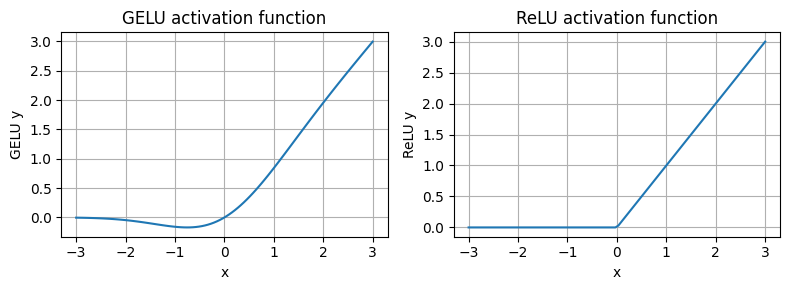

In [5]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
             (x + 0.044715 * torch.pow(x, 3))
        ))

import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} y")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# 实现一个前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# 快捷连接

## 为什么要有快捷连接
缓解梯度消失问题

In [7]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

def print_gradient(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

print("without shortcut")
print_gradient(model_without_shortcut, sample_input)

# 使用shortcut，梯度消失的不会那么快
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print("with shortcut")
print_gradient(model_with_shortcut, sample_input)

without shortcut
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.0.0.bias has gradient mean of 0.00030260381754487753
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.1.0.bias has gradient mean of 0.0008435298805125058
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.2.0.bias has gradient mean of 0.003959516528993845
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.3.0.bias has gradient mean of 0.012068115174770355
layers.4.0.weight has gradient mean of 0.005049645435065031
layers.4.0.bias has gradient mean of 0.0718674585223198
with shortcut
layers.0.0.weight has gradient mean of 0.22169791162014008
layers.0.0.bias has gradient mean of 0.3325468897819519
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.1.0.bias has gradient mean of 0.2764998972415924
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.2.0.bias has gradient mean of 0.43787992000579834
layers.3.0.weight has gradi

# 4.5 构建Transformer模块

In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        context_vec = self.out_proj(context_vec)

        return context_vec

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [9]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# 4.6 实现GPT模型

In [10]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg:dict):
        super().__init__();
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput:\n", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output:
 torch.Size([2, 4, 50257])
tensor([[[ 0.4167, -0.0676, -0.2001,  ...,  0.3916,  0.1081, -0.1607],
         [ 0.3593, -0.6993, -0.8715,  ..., -0.2451,  0.2673, -0.2367],
         [ 1.0220,  0.0540, -0.3235,  ...,  0.0761, -0.5456, -0.1451],
         [-0.8916,  0.4795, -0.2215,  ...,  0.6458,  0.3718,  0.1394]],

        [[-0.4959, -0.2750, -0.0627,  ...,  0.2587,  0.1351, -0.3289],
         [ 0.2549,  0.3801, -0.1802,  ...,  0.6806, -0.0931,  0.4824],
         [ 1.1538,  0.7210, -0.2097,  ...,  0.8688,  0.1912, -0.2601],
         [-0.0953,  0.5321,  0.2437,  ...,  1.2450, -0.1883, -0.0224]]],
       grad_fn=<UnsafeViewBackward0>)


In [12]:
# 了解模型结构
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 163009536


这里看到模型参数量是1.63亿而非1.24亿，这是因为GPT-2使用了权重共享（weight tying）概念，也就是说，原始的GPT-2架构是将词元嵌入层作为输出层重复使用的。

In [13]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


可以看到，tok_emb和out_head的维度都是[50257, 768]，即50257*768=38597376

In [14]:
total_params_gpt2 = (total_params - sum(p.numel() for p in model.out_head.parameters()))
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2}")

Number of trainable parameters considering weight tying: 124412160


此时只有1.24亿参数。

前馈模块和注意力模块的参数量

In [15]:
def count_parameters(model):
    trf_params = sum(p.numel() for p in model.trf_blocks.parameters())
    print(f"Total parameters of transformer: {trf_params}")

    ff_params = 0
    att_params = 0
    trf_norm1_params = 0
    trf_norm2_params = 0
    for trf in model.trf_blocks:
        ff_params += sum(p.numel() for p in trf.ff.parameters())
        att_params += sum(p.numel() for p in trf.att.parameters())
        trf_norm1_params += sum(p.numel() for p in trf.norm1.parameters())
        trf_norm2_params += sum(p.numel() for p in trf.norm2.parameters())


    print(f"Total parameters of ff: {ff_params}")
    print(f"Total parameters of att: {att_params}")
    print(f"Total parameters of trf_norm1: {trf_norm1_params}")
    print(f"Total parameters of trf_norm2: {trf_norm2_params}")
    print(f"Total parameters of trf: {trf_norm1_params + trf_norm2_params + att_params + ff_params}")

count_parameters(model)

Total parameters of transformer: 85026816
Total parameters of ff: 56669184
Total parameters of att: 28320768
Total parameters of trf_norm1: 18432
Total parameters of trf_norm2: 18432
Total parameters of trf: 85026816


下面可见，内存需要 621.83 MB

In [16]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total sizd of the model: {total_size_mb: .2f} MB")

Total sizd of the model:  621.83 MB


# 生成文本

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

model.eval()    # model.eval()，禁用模型中的dropout，dropout只对训练有用，测试时禁用
out = generate_text_simple(
    model, 
    encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"])

print("Output:", out)
print("Output length", len(out[0]))

# 输出的是无意义的结果，因为还没有对模型进行训练
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018,  7283, 46275, 41426, 33167, 33239]])
Output length 10
Hello, I am Feature IT snowballProtect youngstersMu
